In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import random
import time

start = time.process_time()

In [2]:
# defining constants

alpha = 0.4 

sweeps = 20000 # the amount of times we update the M-H path (should change)
tau = 250 # imaginary time, need to change tau 
dtau = 1 # time step
eta = dtau
ntau = int(tau / dtau) # number of time steps 
hitsize = 0.1 # need to test

xlow = - 4 # min x value
xhigh = 4 # max x value
n_xbins = 100 # number of x steps
dx = (xhigh - xlow) / n_xbins # size of x step
x_bins = np.linspace(xlow, xhigh, n_xbins + 1) # x steps

x_path = np.zeros(ntau)

In [3]:
def potential(x):
    
    """
    Defining the potential at some point x
    x: the value at which to determine the potential
    Returns: the double well potential, at that point
    """
    return (alpha * x ** 4) - (2 * x ** 2) + (1 / alpha)

def vary_path(x_current, hitsize):
    
    """
    Picking a random point in the domain.
    x_current: the current point in the x-domain
    Returns: a new point, randomly picked
    """
    x_prime = x_current + np.random.random() * 2 * hitsize - hitsize
    
    while x_prime > xhigh or x_prime < xlow:
        x_prime = x_current + np.random.random() * 2 * hitsize - hitsize
        
    return x_prime

# here I defined the action based on the lagrangian in the final project. 
# this is the exponential portion of eq 3 and 4
def action(x_left, x_right, dtau):
    """
    Determining the action from a left and right point.
    x_left: the left limit of the action potential
    x_right: the right limit of the action potential
    dtau: step size in tau
    Returns: the action
    """
    k = 0.5 * (((x_right - x_left)) ** 2) / dtau
    v = dtau * potential(((x_left + x_right) / 2))
    return k + v

# action S is the integral of the lagrangian. So that is why this can be K + V instead of K - V 
# not used as of right now
def total_action(x_path, dtau):
    """
    Determining the total action across some path.
    x_path: the path across which to determine the action
    dtau: step size in tau
    Returns: the total action
    """
    path_action = 0
    
    for i in range(-1, n_xbins - 1):
        path_action += action(x_path[i], x_path[i + 1], dtau)
        
    return path_action

def delta_action(x_path, prime, i, dtau):
    """
    Determining the difference in action4 across some point and in comparison to another point.
    x_path: the path across which to determine the action
    prime: the other point to compare the action to
    i: the index of the point to compare actions across
    dtau: step size in tau
    Returns: the action difference 
    """
    left = x_path[i - 1]
    right = x_path[i + 1] if i < ntau - 1 else x_path[0] 
    daction = action(left, prime, dtau) + action(prime, right, dtau) 
    daction -= (action(left, x_path[i], dtau) + action(x_path[i], right, dtau))

    return daction

In [4]:
def mcmc(x_path, mean_energies, prob_histogram, n_accept, tau = 250, 
         dtau = 1, hitsize = 0.1, thinning_val = 1): 
    """
    Applying MCMC algorithm to path to find ground state energy, proportional to x^2
    
    x_path: the path across which to apply the MCMC algorithm
    mean_energies: array to save energy values to
    prob_histogram: array to save probability values to
    n_accept: number of accepted values
    tau: imaginary time for algorithm to run across 
    dtau: step size for tau
    hitsize: random interval size to generate value from
    thinning_val: value used to consider for thinning the algorithm, default one
    
    Return: number of accepted values
    """
    ntau = int(tau / dtau)
    
    energy = 0
    
    for i in range(0, ntau, thinning_val):
        
        x_prime = vary_path(x_path[i], hitsize)
        daction = delta_action(x_path, x_prime, i, dtau)
        
        if daction <= 0: 
            x_path[i] = x_prime
            left = x_path[i - 1]
            right = x_path[i + 1] if i < ntau - 1 else x_path[0] 
            energy += action(left, right, dtau)
            n_accept += 1
            
        else:     
            prob = np.exp(- daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
                left = x_path[i - 1]
                right = x_path[i + 1] if i < ntau - 1 else x_path[0]
                energy += action(left, right, dtau)
                n_accept += 1
            else:
                left = x_path[i - 1]
                right = x_path[i + 1] if i < ntau - 1 else x_path[0]
                energy += action(left, right, dtau)
                
#     mean_energies.append(np.mean([i ** 2 for i in x_path]))
    mean_energies.append(energy / ntau)
#     mean_energies.append(total_action(x_path, dtau) / ntau)
    
    hist, _ = np.histogram(x_path, bins = x_bins)
    prob_histogram += hist
    return n_accept
    

100%|█████████████████████████████████████| 10000/10000 [01:40<00:00, 99.49it/s]


0.5891664
0.5879424


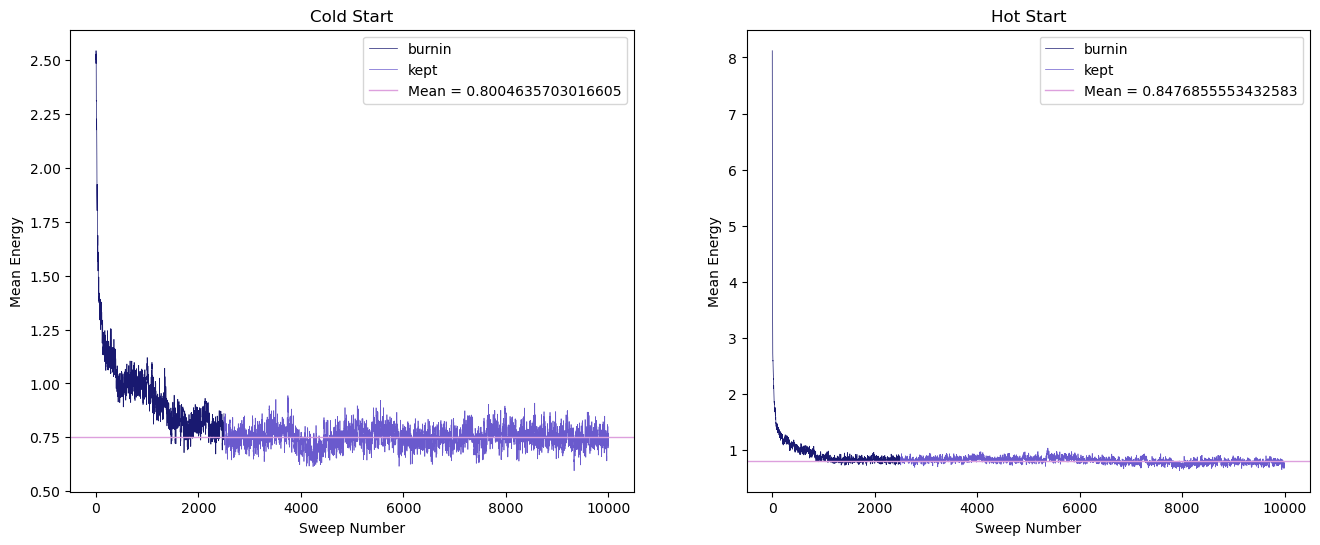

In [5]:
# NEW CELL TO HELP FIGURE OU WHAT XPATH SHOULD BE !

ntau = 500
sweeps = 10000

mean_energies_hot = []
prob_histogram_hot = np.zeros(n_xbins)
x_path_hot = [8 * np.random.random_sample() - 4 for i in range(ntau)]
n_accept_hot = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_hot = mcmc(x_path_hot, mean_energies_hot, prob_histogram_hot, n_accept_hot, tau = 500, hitsize = 1)
    
mean_energies_cold = []
prob_histogram_cold = np.zeros(n_xbins)
x_path_cold = np.zeros(ntau)
n_accept_cold = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_cold = mcmc(x_path_cold, mean_energies_cold, prob_histogram_cold, n_accept_cold, tau = 500, hitsize = 1)
    
print(n_accept_hot / (sweeps * ntau))
print(n_accept_cold / (sweeps * ntau))

fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies_cold))[:2500], mean_energies_cold[:2500], lw = 0.5, color = 'midnightblue', label = 'burnin')
ax[0].plot(range(len(mean_energies_cold))[2500:], mean_energies_cold[2500:], lw = 0.5, color = 'slateblue', label = 'kept')
ax[0].axhline(np.mean(mean_energies_cold[2500:]), lw = 1, color = 'plum', label = 'Mean = {}'.format(np.mean(mean_energies_cold)))
ax[0].set_xlabel('Sweep Number')
ax[0].set_ylabel('Mean Energy')
ax[0].set_title('Cold Start')
ax[0].legend()

ax[1].plot(range(len(mean_energies_hot))[:2500], mean_energies_hot[:2500], lw = 0.5, color = 'midnightblue', label = 'burnin')
ax[1].plot(range(len(mean_energies_hot))[2500:], mean_energies_hot[2500:], lw = 0.5, color = 'slateblue', label = 'kept')
ax[1].axhline(np.mean(mean_energies_hot[2500:]), lw = 1, color = 'plum', label = 'Mean = {}'.format(np.mean(mean_energies_hot)))
ax[1].set_xlabel('Sweep Number')
ax[1].set_ylabel('Mean Energy')
ax[1].set_title('Hot Start')
ax[1].legend()
plt.show()

# doing the mcmc for the number of sweeps (iterations)    

mean_energies = []
prob_histogram = np.zeros(n_xbins)
n_accept = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept = mcmc(x_path, mean_energies, prob_histogram, n_accept)

n_accept / (sweeps * ntau)

fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies)), mean_energies, lw = 0.5, color = 'midnightblue')
ax[0].axhline(np.mean(mean_energies), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies)))
ax[0].legend()

ax[1].stairs(prob_histogram / np.sum(prob_histogram * dx), x_bins, color = 'plum')
ax[1].set_title(f"MCMC, $\\tau = {tau}$, $\delta\\tau= {dtau} $")

plt.show()

# previous iteration was with a cold setting
# now rerun and compare with hot, where the initial path is random

mean_energies_hot = []
prob_histogram_hot = np.zeros(n_xbins)
x_path_hot = np.array([np.random.random() for i in range(ntau)])
n_accept_hot = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_hot = mcmc(x_path_hot, mean_energies_hot, prob_histogram_hot, n_accept_hot)
    
mean_energies_cold = []
prob_histogram_cold = np.zeros(n_xbins)
x_path_cold = np.zeros(ntau)
n_accept_cold = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_cold = mcmc(x_path_cold, mean_energies_cold, prob_histogram_cold, n_accept_cold)
    

fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies_cold)), mean_energies_cold, lw = 0.5, color = 'midnightblue', label = 'Cold start')
ax[0].axhline(np.mean(mean_energies_cold), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_cold)))
ax[0].set_xlabel('Sweep Number')
ax[0].set_ylabel('Mean Energy')
ax[0].legend()

ax[1].plot(range(len(mean_energies_hot)), mean_energies_hot, lw = 0.5, color = 'midnightblue', label = 'Hot start')
ax[1].axhline(np.mean(mean_energies_hot), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_hot)))
ax[1].set_xlabel('Sweep Number')
ax[1].set_ylabel('Mean Energy')
ax[1].legend()

plt.show()

### Conclusion for hot vs cold test:

They are very similar. Hot seems to do marginally better, although not significantly.

Note that I only reran the above two cells like three times lol

Now I try to vary with variations in hitsize.

Parameters:
- hot start
- $\tau$ = 250
- $\delta\tau$ = 1
- thinning value = 1 (no thinning)

mean_energies_half = []
prob_histogram_half = np.zeros(n_xbins)
x_path_half = np.array([np.random.random() for i in range(ntau)])
n_accept_half = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_half = mcmc(x_path_half, mean_energies_half, prob_histogram_half, n_accept_half, hitsize = 0.5)
    
mean_energies_third = []
prob_histogram_third = np.zeros(n_xbins)
x_path_third = np.array([np.random.random() for i in range(ntau)])
n_accept_third = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_third = mcmc(x_path_third, mean_energies_third, prob_histogram_third, n_accept_third, hitsize = 0.33)
    

fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies_half)), mean_energies_half, lw = 0.5, color = 'midnightblue', label = 'Hitsize = 0.5')
ax[0].axhline(np.mean(mean_energies_half), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_half)))
ax[0].set_xlabel('Sweep Number')
ax[0].set_ylabel('Mean Energy')
ax[0].legend()

ax[1].plot(range(len(mean_energies_third)), mean_energies_third, lw = 0.5, color = 'midnightblue', label = 'Hitsize = 0.33')
ax[1].axhline(np.mean(mean_energies_third), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_third)))
ax[1].set_xlabel('Sweep Number')
ax[1].set_ylabel('Mean Energy')
ax[1].legend()

plt.show()

print(n_accept_half / (sweeps * ntau), n_accept_third / (sweeps * ntau))

# increasing hitsize seems to lower acceptance rate

mean_energies_one = []
prob_histogram_one = np.zeros(n_xbins)
x_path_one = np.array([np.random.random() for i in range(ntau)])
n_accept_one = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_one = mcmc(x_path_one, mean_energies_one, prob_histogram_one, n_accept_one, hitsize = 1)
    
mean_energies_five = []
prob_histogram_five = np.zeros(n_xbins)
x_path_five = np.array([np.random.random() for i in range(ntau)])
n_accept_five = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_five = mcmc(x_path_five, mean_energies_five, prob_histogram_five, n_accept_five, hitsize = 0.33)
    

fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies_one)), mean_energies_one, lw = 0.5, color = 'midnightblue', label = 'Hitsize = 1')
ax[0].axhline(np.mean(mean_energies_one), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_one)))
ax[0].set_xlabel('Sweep Number')
ax[0].set_ylabel('Mean Energy')
ax[0].legend()

ax[1].plot(range(len(mean_energies_five)), mean_energies_five, lw = 0.5, color = 'midnightblue', label = 'Hitsize = 5')
ax[1].axhline(np.mean(mean_energies_five), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_five)))
ax[1].set_xlabel('Sweep Number')
ax[1].set_ylabel('Mean Energy')
ax[1].legend()

plt.show()

print(n_accept_one / (sweeps * ntau), n_accept_five / (sweeps * ntau))

### Conclusion for hitsize:

Hitsize of around 1 seems to be the right, leading to roughly 60% acceptance rate as of right now. Now we adjust the $\delta\tau$

Parameters: 
- hot start
- $\tau$ = 250
- hitsize = 1
- thinning value = 1 (no thinning)

# changing delta tau

ntau_dfive = int(250 / 0.5)
mean_energies_dfive = []
prob_histogram_dfive = np.zeros(n_xbins)
x_path_dfive = np.array([np.random.random() for i in range(ntau_dfive)])
n_accept_dfive = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_dfive = mcmc(x_path_dfive, mean_energies_dfive, prob_histogram_dfive, n_accept_dfive, dtau = 0.5, hitsize = 1)
    
ntau_dten = int(250 / 0.1)
mean_energies_dten = []
prob_histogram_dten = np.zeros(n_xbins)
x_path_dten = np.array([np.random.random() for i in range(ntau_dten)])
n_accept_dten = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_dten = mcmc(x_path_dten, mean_energies_dten, prob_histogram_dten, n_accept_dten, dtau = 0.10, hitsize = 1)
    

fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies_dfive)), mean_energies_dfive, lw = 0.5, color = 'midnightblue', label = f"$\delta\\tau$ = 0.5")
ax[0].axhline(np.mean(mean_energies_dfive), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_dfive)))
ax[0].set_xlabel('Sweep Number')
ax[0].set_ylabel('Mean Energy')
ax[0].legend()

ax[1].plot(range(len(mean_energies_dten)), mean_energies_dten, lw = 0.5, color = 'midnightblue', label = f"$\delta\\tau$ = 0.10")
ax[1].axhline(np.mean(mean_energies_dten), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_dten)))
ax[1].set_xlabel('Sweep Number')
ax[1].set_ylabel('Mean Energy')
ax[1].legend()

plt.show()

print(n_accept_dfive / (sweeps * int(tau / 0.5)), n_accept_dten / (sweeps * int(tau / 0.10)))

### Conclusion: 

Smaller $\delta\tau$ seems to require a shorter burn-in

In either case, the $\delta\tau$ does not seem too critical, although the smaller value, 0.10, results in more steps being taken and is messier. 

We will continue with $\delta\tau$ being 1, and changing $\tau$.

Parameters: 
- hot start
- $\delta\tau$ = 1
- hitsize = 1
- thinning value = 1 (no thinning)

# changing tau

ntau_1000 = 1000 
mean_energies_1000 = []
prob_histogram_1000 = np.zeros(n_xbins)
x_path_1000 = np.array([np.random.random() for i in range(ntau_1000)])
n_accept_1000 = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_1000 = mcmc(x_path_1000, mean_energies_1000, prob_histogram_1000, n_accept_1000, tau = 1000, hitsize = 1)
    
ntau_5000 = 5000
mean_energies_5000 = []
prob_histogram_5000 = np.zeros(n_xbins)
x_path_5000 = np.array([np.random.random() for i in range(ntau_5000)])
n_accept_5000 = 0

for i in tqdm.tqdm(range(sweeps)):
    n_accept_5000 = mcmc(x_path_5000, mean_energies_5000, prob_histogram_5000, n_accept_5000, tau = 5000, hitsize = 1)
    

fig, ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].plot(range(len(mean_energies_1000)), mean_energies_1000, lw = 0.5, color = 'midnightblue', label = f"$\delta\\tau$ = 0.5")
ax[0].axhline(np.mean(mean_energies_1000), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_1000)))
ax[0].set_xlabel('Sweep Number')
ax[0].set_ylabel('Mean Energy')
ax[0].legend()

ax[1].plot(range(len(mean_energies_5000)), mean_energies_5000, lw = 0.5, color = 'midnightblue', label = f"$\delta\\tau$ = 0.10")
ax[1].axhline(np.mean(mean_energies_5000), lw = 1, color = 'slateblue', label = 'Mean of means = {}'.format(np.mean(mean_energies_5000)))
ax[1].set_xlabel('Sweep Number')
ax[1].set_ylabel('Mean Energy')
ax[1].legend()

plt.show()

print(n_accept_dfive / (sweeps * int(tau / 0.5)), n_accept_dten / (sweeps * int(tau / 0.10)))

### Conclusion:

An increase in $\tau$ corresponds with a shorter burn in time.

Overall, we can also see that we don't need 20,000 sweeps. In every iteration of the MCMC simulation run thus far, we can see that the simulation converges either before or around the 25000 mark. Therefore, we can use 10,000 sweeps instead, shortening the run time and computational requirements. 

In [7]:
print((time.process_time() - start) / 60, 'minutes')

2.2468319333333335 minutes
